In [1]:
import asyncio
import time
from mpyc.runtime import mpc
from mpyc import asyncoro
import mpyc
import mpyc.gmpy
import numpy as np
import statsmodels.api as sm
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest

In [2]:
import pandas as pd
breast = load_breast_cancer()
y = breast.target
X = breast.data.data
X = MinMaxScaler().fit(X).transform(X)
X = SelectKBest(k=5).fit_transform(X, y)
X = sm.add_constant(X)

In [3]:
import asyncio
from mpyc.runtime import mpc
from mpyc import asyncoro
import mpyc.gmpy

def factorial(x):
    res = 1
    for i in range(1,x+1):
        res = res*i
    return res

def exp(z):
    ftol = 1e-5
    exp_val = _exp(mpc.if_else(z < 0, -1, 1) * z, ftol)
    return mpc.if_else(z < 0, 1/exp_val, exp_val)

@asyncoro.mpc_coro
async def _exp(z, ftol):
    res = 1
    for i in range(1, 50):
        term = (z**i)/factorial(i)
        res += term
        if await mpc.output(term < ftol): break
    return res

In [4]:
def log(x, q=3):
    ftol = 1e-5
    q = 4
    r = 0
    for _ in range(20):
        s = (x > q)
        x /= mpc.if_else(s, q, 1.0)
        r += 1 * s
    return _log(x, ftol) + r * 1.3862943611198906188

@asyncoro.mpc_coro
async def _log(x, ftol):
    ratio = (x-1)/(x+1)
    res = 0
    for i in range(1,100,2):
        term = 2*(ratio**i)/i
        res += term
        if await mpc.output(mpc.abs(term) < ftol): break
    return res


In [5]:
class SecureLogistic:

    def __init__(self, y, X):
        self.secfloat = mpc.SecFxp(128)
        if type(y) is np.ndarray:
            y = self.secfloat.array(y)
        if type(X) is np.ndarray:
            X = self.secfloat.array(X)
        self.y = y
        self.X = X
        self.n_obs = len(y)

    def fit(self, maxiter=1):
        self.betas = []
        beta = self.secfloat.array(np.zeros(self.X.shape[1]))
        for i in range(maxiter):
            self.betas.append(beta)
            score = self.score(beta)
            hessian = self.hessian(beta)
            beta += self.np_inv(hessian) @ score
            print(f"iter {i} completed")
        self.betas.append(beta)
        return beta

    def likelihood(self):
        pass

    def score(self, beta):
        Xb = self.X @ beta
        exp_Xb = self.apply_exp(-Xb)
        self.S = 1/(1+exp_Xb)
        return (self.y - self.S) @ self.X / self.n_obs

    def hessian(self, beta):
        return mpc.np_multiply(self.X.T, self.S * (1 - self.S)) @ self.X / self.n_obs

    def apply_exp(self, X):
        X = X.copy()
        for i in range(len(X)):
            mpc.np_update(X, i, exp(X[i]))
        return X
    
    def np_inv(self, A, niter=100):
        n = A.shape[0]
        X_k = self.secfloat.array(np.eye(n)) / self.norm_1(A)
        for k in range(niter):
            X_k_next = 2 * X_k - X_k @ A @ X_k     
            X_k = X_k_next    
        return X_k_next
        
    def norm_1(self, A):
        n = mpc.np_sgn(A) * A
        n = mpc.np_sum(n, axis=0)
        n = mpc.np_amax(n)
        return n

In [57]:
results = {}

In [48]:
for x in range(1, 11):
    rng = np.random.default_rng(42)
    idx = rng.integers(len(y), size=int(len(y) * x/10))
    X_sample = X[idx]
    y_sample = y[idx]
    t0 = time.time()
    model = SecureLogistic(y_sample, X_sample)
    params_smpc = await mpc.output(model.fit(maxiter=1))
    t1 = time.time()
    params_global = sm.Logit(y_sample, X_sample).fit(maxiter=10).params
    t2 = time.time()
    time_smpc = t1 - t0
    time_global = (t2 - t1)/10
    results[x/10] = [time_smpc, time_smpc/time_global, params_smpc, params_global]
    print(results)

iter 0 completed
         Current function value: 0.049771
         Iterations: 10
{0.1: [9.137363910675049, 40393.00379426644, array([ 3.33301965, -2.68917765, -4.85479941, -0.08392921, -2.51032004,
       -0.08892826]), array([  53.94821575, -167.46577346, -154.99326594,  189.30769431,
       -114.07969193,   47.96164947])]}


/home/bob/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


iter 0 completed
         Current function value: 0.089140
         Iterations: 10
{0.1: [9.137363910675049, 40393.00379426644, array([ 3.33301965, -2.68917765, -4.85479941, -0.08392921, -2.51032004,
       -0.08892826]), array([  53.94821575, -167.46577346, -154.99326594,  189.30769431,
       -114.07969193,   47.96164947])], 0.2: [12.574117422103882, 51119.192594746535, array([ 3.3134168 , -0.83637212, -5.1942931 , -5.60936309,  1.62836676,
       -0.15270031]), array([ 10.66796301,  21.81207502, -31.3138881 , -29.89428384,
       -24.72991191,  12.82704436])]}


/home/bob/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


iter 0 completed
         Current function value: 0.084564
         Iterations: 10
{0.1: [9.137363910675049, 40393.00379426644, array([ 3.33301965, -2.68917765, -4.85479941, -0.08392921, -2.51032004,
       -0.08892826]), array([  53.94821575, -167.46577346, -154.99326594,  189.30769431,
       -114.07969193,   47.96164947])], 0.2: [12.574117422103882, 51119.192594746535, array([ 3.3134168 , -0.83637212, -5.1942931 , -5.60936309,  1.62836676,
       -0.15270031]), array([ 10.66796301,  21.81207502, -31.3138881 , -29.89428384,
       -24.72991191,  12.82704436])], 0.3: [16.34038209915161, 73711.04538610454, array([ 3.40651239,  0.26830328, -2.89736974, -8.75198622,  2.78121065,
       -1.17531498]), array([ 11.86226262,  21.28955248, -26.75340843, -25.74450429,
       -27.32821538,   7.17890186])]}


/home/bob/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


iter 0 completed
         Current function value: 0.100167
         Iterations: 10
{0.1: [9.137363910675049, 40393.00379426644, array([ 3.33301965, -2.68917765, -4.85479941, -0.08392921, -2.51032004,
       -0.08892826]), array([  53.94821575, -167.46577346, -154.99326594,  189.30769431,
       -114.07969193,   47.96164947])], 0.2: [12.574117422103882, 51119.192594746535, array([ 3.3134168 , -0.83637212, -5.1942931 , -5.60936309,  1.62836676,
       -0.15270031]), array([ 10.66796301,  21.81207502, -31.3138881 , -29.89428384,
       -24.72991191,  12.82704436])], 0.3: [16.34038209915161, 73711.04538610454, array([ 3.40651239,  0.26830328, -2.89736974, -8.75198622,  2.78121065,
       -1.17531498]), array([ 11.86226262,  21.28955248, -26.75340843, -25.74450429,
       -27.32821538,   7.17890186])], 0.4: [19.99330973625183, 76498.83141762452, array([ 3.27186407,  1.87848317, -3.18484403, -7.01105994, -0.46914062,
       -1.22212201]), array([ 11.35457219,  36.07970373, -21.62129832, -53.

/home/bob/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


iter 0 completed
         Current function value: 0.095278
         Iterations: 10
{0.1: [9.137363910675049, 40393.00379426644, array([ 3.33301965, -2.68917765, -4.85479941, -0.08392921, -2.51032004,
       -0.08892826]), array([  53.94821575, -167.46577346, -154.99326594,  189.30769431,
       -114.07969193,   47.96164947])], 0.2: [12.574117422103882, 51119.192594746535, array([ 3.3134168 , -0.83637212, -5.1942931 , -5.60936309,  1.62836676,
       -0.15270031]), array([ 10.66796301,  21.81207502, -31.3138881 , -29.89428384,
       -24.72991191,  12.82704436])], 0.3: [16.34038209915161, 73711.04538610454, array([ 3.40651239,  0.26830328, -2.89736974, -8.75198622,  2.78121065,
       -1.17531498]), array([ 11.86226262,  21.28955248, -26.75340843, -25.74450429,
       -27.32821538,   7.17890186])], 0.4: [19.99330973625183, 76498.83141762452, array([ 3.27186407,  1.87848317, -3.18484403, -7.01105994, -0.46914062,
       -1.22212201]), array([ 11.35457219,  36.07970373, -21.62129832, -53.

/home/bob/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


iter 0 completed
         Current function value: 0.085412
         Iterations: 10
{0.1: [9.137363910675049, 40393.00379426644, array([ 3.33301965, -2.68917765, -4.85479941, -0.08392921, -2.51032004,
       -0.08892826]), array([  53.94821575, -167.46577346, -154.99326594,  189.30769431,
       -114.07969193,   47.96164947])], 0.2: [12.574117422103882, 51119.192594746535, array([ 3.3134168 , -0.83637212, -5.1942931 , -5.60936309,  1.62836676,
       -0.15270031]), array([ 10.66796301,  21.81207502, -31.3138881 , -29.89428384,
       -24.72991191,  12.82704436])], 0.3: [16.34038209915161, 73711.04538610454, array([ 3.40651239,  0.26830328, -2.89736974, -8.75198622,  2.78121065,
       -1.17531498]), array([ 11.86226262,  21.28955248, -26.75340843, -25.74450429,
       -27.32821538,   7.17890186])], 0.4: [19.99330973625183, 76498.83141762452, array([ 3.27186407,  1.87848317, -3.18484403, -7.01105994, -0.46914062,
       -1.22212201]), array([ 11.35457219,  36.07970373, -21.62129832, -53.

/home/bob/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


iter 0 completed
         Current function value: 0.092245
         Iterations: 10
{0.1: [9.137363910675049, 40393.00379426644, array([ 3.33301965, -2.68917765, -4.85479941, -0.08392921, -2.51032004,
       -0.08892826]), array([  53.94821575, -167.46577346, -154.99326594,  189.30769431,
       -114.07969193,   47.96164947])], 0.2: [12.574117422103882, 51119.192594746535, array([ 3.3134168 , -0.83637212, -5.1942931 , -5.60936309,  1.62836676,
       -0.15270031]), array([ 10.66796301,  21.81207502, -31.3138881 , -29.89428384,
       -24.72991191,  12.82704436])], 0.3: [16.34038209915161, 73711.04538610454, array([ 3.40651239,  0.26830328, -2.89736974, -8.75198622,  2.78121065,
       -1.17531498]), array([ 11.86226262,  21.28955248, -26.75340843, -25.74450429,
       -27.32821538,   7.17890186])], 0.4: [19.99330973625183, 76498.83141762452, array([ 3.27186407,  1.87848317, -3.18484403, -7.01105994, -0.46914062,
       -1.22212201]), array([ 11.35457219,  36.07970373, -21.62129832, -53.

/home/bob/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


iter 0 completed
         Current function value: 0.096478
         Iterations: 10
{0.1: [9.137363910675049, 40393.00379426644, array([ 3.33301965, -2.68917765, -4.85479941, -0.08392921, -2.51032004,
       -0.08892826]), array([  53.94821575, -167.46577346, -154.99326594,  189.30769431,
       -114.07969193,   47.96164947])], 0.2: [12.574117422103882, 51119.192594746535, array([ 3.3134168 , -0.83637212, -5.1942931 , -5.60936309,  1.62836676,
       -0.15270031]), array([ 10.66796301,  21.81207502, -31.3138881 , -29.89428384,
       -24.72991191,  12.82704436])], 0.3: [16.34038209915161, 73711.04538610454, array([ 3.40651239,  0.26830328, -2.89736974, -8.75198622,  2.78121065,
       -1.17531498]), array([ 11.86226262,  21.28955248, -26.75340843, -25.74450429,
       -27.32821538,   7.17890186])], 0.4: [19.99330973625183, 76498.83141762452, array([ 3.27186407,  1.87848317, -3.18484403, -7.01105994, -0.46914062,
       -1.22212201]), array([ 11.35457219,  36.07970373, -21.62129832, -53.

/home/bob/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


iter 0 completed
         Current function value: 0.091965
         Iterations: 10
{0.1: [9.137363910675049, 40393.00379426644, array([ 3.33301965, -2.68917765, -4.85479941, -0.08392921, -2.51032004,
       -0.08892826]), array([  53.94821575, -167.46577346, -154.99326594,  189.30769431,
       -114.07969193,   47.96164947])], 0.2: [12.574117422103882, 51119.192594746535, array([ 3.3134168 , -0.83637212, -5.1942931 , -5.60936309,  1.62836676,
       -0.15270031]), array([ 10.66796301,  21.81207502, -31.3138881 , -29.89428384,
       -24.72991191,  12.82704436])], 0.3: [16.34038209915161, 73711.04538610454, array([ 3.40651239,  0.26830328, -2.89736974, -8.75198622,  2.78121065,
       -1.17531498]), array([ 11.86226262,  21.28955248, -26.75340843, -25.74450429,
       -27.32821538,   7.17890186])], 0.4: [19.99330973625183, 76498.83141762452, array([ 3.27186407,  1.87848317, -3.18484403, -7.01105994, -0.46914062,
       -1.22212201]), array([ 11.35457219,  36.07970373, -21.62129832, -53.

/home/bob/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


iter 0 completed
         Current function value: 0.090243
         Iterations: 10
{0.1: [9.137363910675049, 40393.00379426644, array([ 3.33301965, -2.68917765, -4.85479941, -0.08392921, -2.51032004,
       -0.08892826]), array([  53.94821575, -167.46577346, -154.99326594,  189.30769431,
       -114.07969193,   47.96164947])], 0.2: [12.574117422103882, 51119.192594746535, array([ 3.3134168 , -0.83637212, -5.1942931 , -5.60936309,  1.62836676,
       -0.15270031]), array([ 10.66796301,  21.81207502, -31.3138881 , -29.89428384,
       -24.72991191,  12.82704436])], 0.3: [16.34038209915161, 73711.04538610454, array([ 3.40651239,  0.26830328, -2.89736974, -8.75198622,  2.78121065,
       -1.17531498]), array([ 11.86226262,  21.28955248, -26.75340843, -25.74450429,
       -27.32821538,   7.17890186])], 0.4: [19.99330973625183, 76498.83141762452, array([ 3.27186407,  1.87848317, -3.18484403, -7.01105994, -0.46914062,
       -1.22212201]), array([ 11.35457219,  36.07970373, -21.62129832, -53.

/home/bob/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


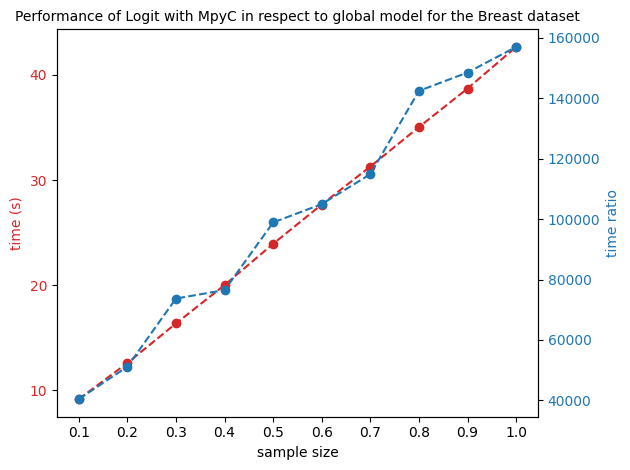

In [50]:
import matplotlib.pyplot as plt
import numpy as np


# Create some mock data
ks = [x/10 for x in range(1,11)]

data1 = [results[k][0] for k in ks]
data2 = [results[k][1] for k in ks]

fig, ax1 = plt.subplots()


color = 'tab:red'
ax1.set_title("Performance of Logit with MpyC in respect to global model for the Breast dataset", fontsize=10)
ax1.set_xlabel('sample size')
ax1.set_ylabel('time (s)', color=color)
ax1.plot(ks, data1, "o--", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(ks)
ax1.set_yticks(list(range(10, 45, 10)))


ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('time ratio', color=color)  # we already handled the x-label with ax1
ax2.plot(ks, data2, "o--", color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("performance_smpc.png", dpi=300)
plt.show()

In [33]:
model = SecureLogistic(y, X)
params_smpc = await mpc.output(model.fit(maxiter=15))
beta_history = [(await mpc.output(x)) for x in model.betas]
params_global = sm.Logit(y, X).fit(maxiter=15).params

iter 0 completed
iter 1 completed
iter 2 completed
iter 3 completed
iter 4 completed
iter 5 completed
iter 6 completed
iter 7 completed
iter 8 completed
iter 9 completed
iter 10 completed
iter 11 completed
iter 12 completed
iter 13 completed
iter 14 completed
Optimization terminated successfully.
         Current function value: 0.109447
         Iterations 10


/tmp/ipykernel_6474/4080796033.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


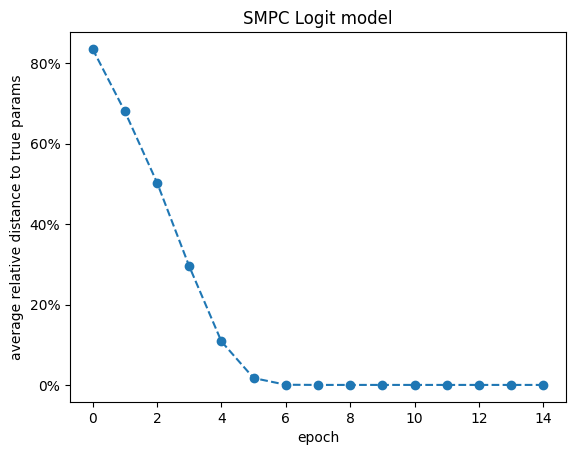

In [37]:
import matplotlib.pyplot as plt
import numpy as np

diffs = [sum(np.abs((x - params_global) / params_global)) / len(params_global) for x in beta_history]

plt.plot(range(len(diffs)), diffs, "o--")
plt.title("SMPC Logit model")
plt.xlabel("epoch")
plt.ylabel("average relative distance to true params")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.savefig(f"Logit_SMPC_convergence", dpi=300)
plt.show()